# CREATE A COPY FIRST!

# **Question 3: Multi-Class Segmentation for Animal Parts**

In this question, you should finetune a **pretrained U-Net** model for **multi-class segmentation** of animal parts. Your segmentation model will classify each pixel into **one of 5 classes** (Tail, Body, Legs, Head, Background).

Complete the code cells below.

---

In [2]:
# # Please uncomment this out when you are running this lab on google colab!
import os

# # Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammad2012191/segmentation")

print("Path to dataset files:", path)

Path to dataset files: /content/data/datasets/mohammad2012191/segmentation/versions/1


## **TASK 1: Dataset Class**
- Build a custom dataset class to load images and masks.
- Prepare your train and validation dataloaders.
- Display some images and their corresponding masks.



Total training images: 1737
Total validation images: 435


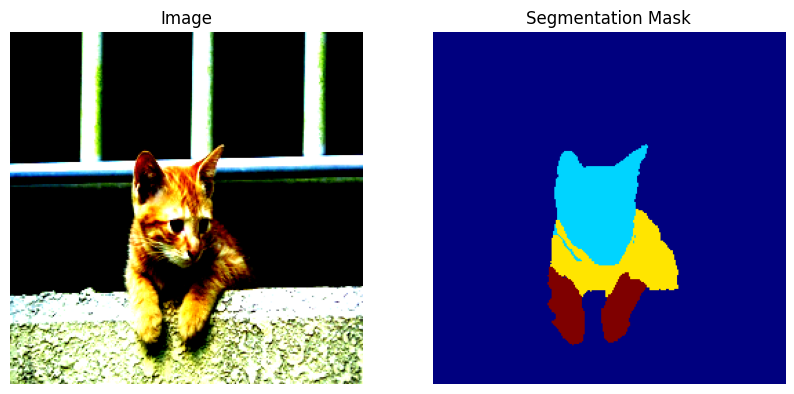

In [4]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import kagglehub

TRAIN_IMAGE_DIR = os.path.join(path, "train", "images")
TRAIN_MASK_DIR = os.path.join(path, "train", "masks")
VAL_IMAGE_DIR = os.path.join(path, "val", "images")
VAL_MASK_DIR = os.path.join(path, "val", "masks")

class AnimalSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform
        self.mask_transform = mask_transform

        if len(self.image_paths) == 0 or len(self.mask_paths) == 0:
            raise ValueError(f"Dataset is empty! Check paths: {image_dir}, {mask_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

#load train and validation Datasets
train_dataset = AnimalSegmentationDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, transform=image_transform, mask_transform=mask_transform)
val_dataset = AnimalSegmentationDataset(VAL_IMAGE_DIR, VAL_MASK_DIR, transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

#display info
print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")

#show a sample
def show_sample(dataset, idx=0):
    image, mask = dataset[idx]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(mask.squeeze(), cmap="jet")
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    plt.show()

#show
show_sample(train_dataset)


## **TASK 2: Model Class**
- **Use a pretrained U-Net** (from `segmentation_models_pytorch`) with "efficientnet-b0" as an encoder.

In [5]:
import torch
import torch.nn as nn
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b0",  #EfficientNet-B0 as the backbone
    encoder_weights="imagenet",  #pretrained weights
    in_channels=3,  # RGB
    classes=5  # 5
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print Model Summary
print(model)


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

## **TASK 3: Training and Validation Loops**
- Define the training and validation loops.

In [8]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.squeeze(1).long().to(device)


        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.squeeze(1).long().to(device)
            outputs = model(images)
            loss = criterion(outputs, masks.long())
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


## **TASK 4: Running Training**
- Define the loss and the optimizer.
- Train the model for 10 epochs.
- Print the training and validation losses.
- Plot loss curve.

Epoch 1/10, Train Loss: 1.1770, Val Loss: 0.7265
Epoch 2/10, Train Loss: 0.5785, Val Loss: 0.4727
Epoch 3/10, Train Loss: 0.4178, Val Loss: 0.3893
Epoch 4/10, Train Loss: 0.3440, Val Loss: 0.3423
Epoch 5/10, Train Loss: 0.2976, Val Loss: 0.3150
Epoch 6/10, Train Loss: 0.2683, Val Loss: 0.2964
Epoch 7/10, Train Loss: 0.2479, Val Loss: 0.2917
Epoch 8/10, Train Loss: 0.2319, Val Loss: 0.2791
Epoch 9/10, Train Loss: 0.2096, Val Loss: 0.2708
Epoch 10/10, Train Loss: 0.1949, Val Loss: 0.2703


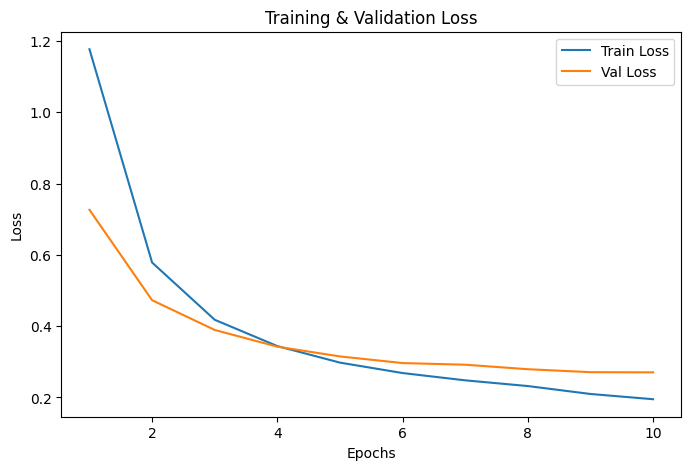

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


## **TASK 5: Visualizing Predictions**
- Visualize your model's predictions against the ground truth for several images.

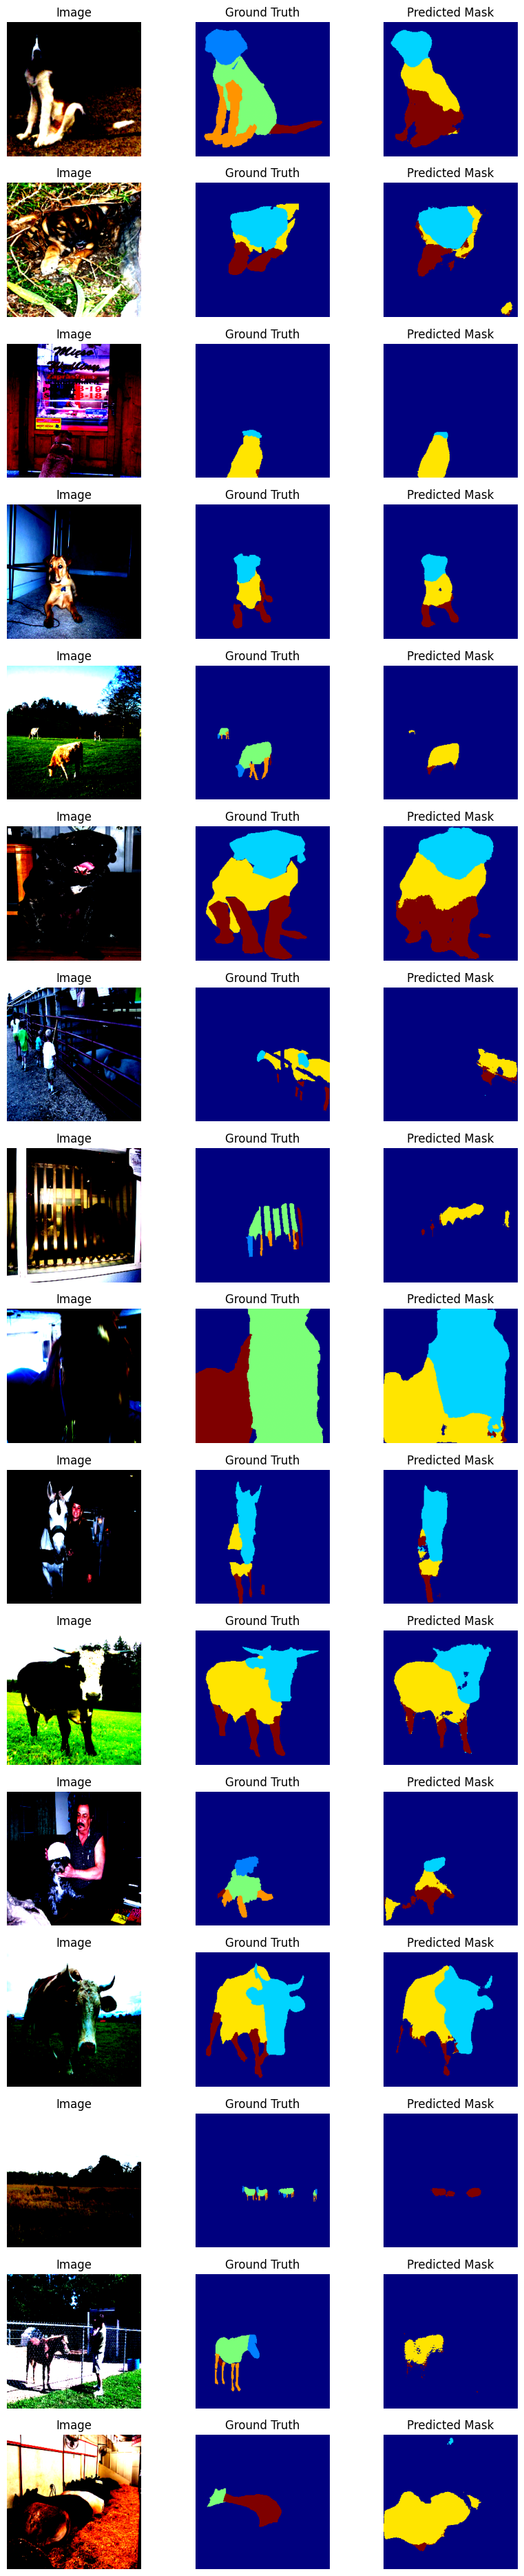

In [10]:
def visualize_predictions(model, dataloader, device):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.squeeze(1).long().to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    fig, axes = plt.subplots(len(images), 3, figsize=(10, len(images) * 3))
    for i in range(len(images)):
        axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0))
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(masks[i].cpu(), cmap="jet")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(preds[i].cpu(), cmap="jet")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.show()

visualize_predictions(model, val_loader, device)

# **BONUS Task: Using Dice Loss & Dice Coefficient**

**Dice loss** and **Dice coefficient** are widely used metrics for evaluating segmentation models. We typically use **Dice loss** during training because it is **differentiable**, and then calculate the **Dice coefficient** as a metric to measure performance—similar to how we use cross-entropy loss for training and accuracy for evaluation.


## **Your Bonus Tasks:**
- **Retrain** your previously built segmentation model using the **Dice loss** provided below.
- **Modify the validation function** to evaluate your retrained model using the **Dice coefficient** metric provided below.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dice Loss for multiclass segmentation (Lower is better)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (inputs * targets).sum(dim=(2, 3))
        total = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

        dice_score = (2 * intersection + self.smooth) / (total + self.smooth)
        dice_loss = 1 - dice_score.mean()

        return dice_loss

# Dice Coefficient Metric (Higher is better)
def dice_coefficient(inputs, targets, smooth=1e-5):
    inputs = F.softmax(inputs, dim=1)
    targets = targets.squeeze(1)
    targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

    intersection = (inputs * targets).sum(dim=(2, 3))
    total = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

    dice_score = (2 * intersection + smooth) / (total + smooth)

    return dice_score.mean().item()


In [ ]:
# TO DO